# Colab preinstall

In [ ]:
!uv pip install ipympl
# restart to apply changes
import os
os.kill(os.getpid(), 9)

Using Python 3.11.13 environment at: /usr
Resolved 75 packages in 428ms
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
ipympl     ------------------------------     0 B/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 16.00 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 16.00 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 32.00 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 48.00 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 61.80 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 

In [30]:
from google.colab import output
output.enable_custom_widget_manager()

# Imports

In [1]:
from numpy import dtype
import torch
import torch.functional as F
import matplotlib.pyplot as plt
import tqdm
from typing import Callable
from pathlib import Path

%matplotlib ipympl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

# Model definition. Same as in paper

In [2]:
non_linear_f = torch.nn.Tanh
layers_sizes = (2, 64, 128, 256, 256, 128, 64, 1)


class MyModel(torch.nn.Module):
    def __init__(self, dtype):
        super(MyModel, self).__init__()
        layers = []
        ins = layers_sizes[0]
        for clayer in layers_sizes[1:-1]:
            layers.append(torch.nn.Linear(ins, clayer, dtype=dtype))
            layers.append(non_linear_f())
            ins = clayer
        layers.append(torch.nn.Linear(ins, layers_sizes[-1]))
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [3]:
# Using L1 loss because working with complex numbers, MSE does not support them
loss_f = torch.nn.L1Loss()

In [6]:
model = MyModel(dtype=dtype).to(device)

## Loading weights if they are exist

In [5]:
weights_path = "weights_random.pt"
if Path(weights_path).is_file():
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()

# Problem

$$i \frac{\partial \psi}{\partial t} = -k \frac{\partial^2 \psi}{\partial x^2} - \gamma |\psi|^2 \psi$$

$$\psi(0, x) = 2 sech x $$

In [7]:
psi = 0
k = 0.5
gamma = 1
N = 2
f = lambda psi: gamma * torch.abs(psi) ** 2

# Loss functions

In [8]:
def loss_IC(y_IC, x):
    # t = 0
    return loss_f(y_IC, N * 1 / torch.cosh(x))

In [9]:
def residual(y, x, t):
    dudt = torch.autograd.grad(y, t, torch.ones_like(y, device=device, dtype=dtype), create_graph=True)[0]
    dudx = torch.autograd.grad(y, x, torch.ones_like(y, device=device, dtype=dtype), create_graph=True)[0]
    du2dx2 = torch.autograd.grad(dudx, x, torch.ones_like(y, device=device, dtype=dtype), create_graph=True)[0]
    return 0+1j * dudt + k*du2dx2 + f(y) * y

In [10]:
def loss_PDE(y, x, t):
    return loss_f(residual(y, x, t), torch.zeros_like(y, device=device, dtype=dtype))

# TRAINING

In [12]:
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1000)

In [13]:
x_bounds = (-15, 15)
t_bounds = (0, torch.pi / 2)
EPOCHS_NUM = 5000
PDE_POINTS_NUM = 20000
IC_POINTS_NUM = 2000

In [16]:
for i in tqdm.tqdm(range(EPOCHS_NUM)):
    x_pde = torch.rand(PDE_POINTS_NUM, device=device) * (x_bounds[1] - x_bounds[0]) + x_bounds[0]
    t_pde = torch.rand(PDE_POINTS_NUM, device=device) * (t_bounds[1] - t_bounds[0]) + t_bounds[0]
    x_pde.requires_grad = True
    t_pde.requires_grad = True
    xt_pde = torch.stack((x_pde, t_pde), dim=1)
    x_ic = torch.rand(IC_POINTS_NUM, device=device) * (x_bounds[1] - x_bounds[0]) + x_bounds[0]
    x_ic.requires_grad = True
    t_ic = torch.zeros_like(x_ic, device=device)
    t_ic.requires_grad = True
    xt_ic = torch.stack((x_ic, t_ic), dim=1)
    optim.zero_grad()
    y_pde = model(xt_pde).squeeze()
    y_ic = model(xt_ic).squeeze()
    closs = loss_PDE(y_pde, x_pde, t_pde) + loss_IC(y_ic, x_ic)
    closs.backward()
    optim.step()
    lr_scheduler.step()
    if i % 100 == 0:
        print(closs, optim.param_groups[0]['lr'])

  0%|          | 0/5000 [00:00<?, ?it/s]/home/alex1um/Desktop/Projects/IKKN/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 1/5000 [00:01<1:35:36,  1.15s/it]

tensor(0.2115, device='cuda:0', grad_fn=<AddBackward0>) 0.001


  2%|▏         | 101/5000 [00:30<40:04,  2.04it/s]

tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>) 0.001


  3%|▎         | 135/5000 [00:41<24:38,  3.29it/s]


KeyboardInterrupt: 

# pLOTTING

### Abs of residual printing (basicly this is error)

Very small values along full area

/home/alex1um/Desktop/Projects/IKKN/.venv/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


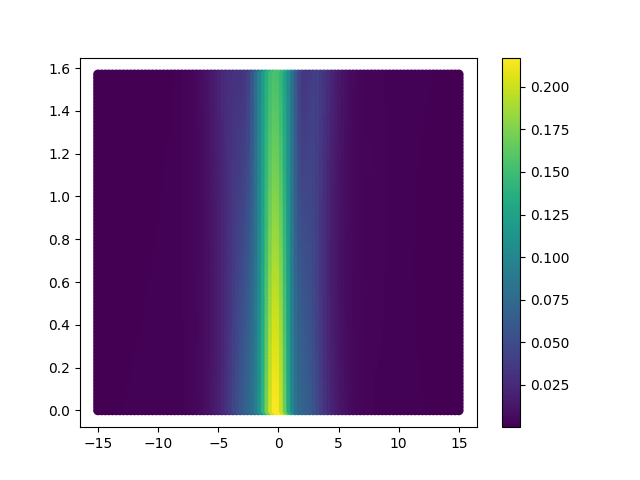

In [17]:
x_coords = torch.linspace(-15, 15, 100, device=device, dtype=dtype)
y_coords = torch.linspace(0, torch.pi / 2, 100, device=device, dtype=dtype)
x_coords.requires_grad = True
y_coords.requires_grad = True
grid_x, grid_y = torch.meshgrid(x_coords, y_coords)
grid_x = grid_x.ravel()
grid_y = grid_y.ravel()
# 2. Evaluate the function at the initial grid points
# The function is expected to handle a batch of points
xy = torch.stack((grid_x, grid_y), dim=1)
guess = model(xy).ravel()
z = residual(guess, grid_x, grid_y)
n = z.mean()
# z = loss(z, torch.zeros_like(z, device=device, dtype=dtype))
z = z.abs()

# function_values = res_for_generate(grid_x, grid_y)
fig, ax = plt.subplots()
sc = ax.scatter(grid_x.cpu().detach(), grid_y.cpu().detach(), c=z.detach().cpu())
fig.colorbar(sc)

### Full area points generation with model values

In [18]:
t = torch.linspace(0, torch.pi * 2, 100, dtype=dtype, device=device)
t.requires_grad = True
x = torch.linspace(-15, 15, 100, dtype=dtype, device=device)
x.requires_grad = True
grid_x, grid_t = torch.meshgrid(x, t)
shape = grid_x.shape
X = grid_x.ravel()
T = grid_t.ravel()
XT = torch.stack((X, T), dim=1)
Y = model(XT).ravel()
loss_y = torch.abs(residual(Y, X, T))

x = X.cpu().detach()
t = T.cpu().detach()
y = Y.cpu().detach()
grid_y = y.reshape(shape)
loss_y = loss_y.cpu().detach()
grid_loss_y = loss_y.reshape(shape)
grid_x = grid_x.cpu().detach()
grid_t = grid_t.cpu().detach()

/tmp/ipykernel_31002/4132490833.py:12: UserWarning: The following kwargs were not used by contour: 's'
  sc = ax21.contourf(grid_x, grid_t, grid_y, s=10)
/tmp/ipykernel_31002/4132490833.py:13: UserWarning: The following kwargs were not used by contour: 's'
  sc2 = ax22.contourf(grid_x, grid_t, grid_loss_y, s=10)


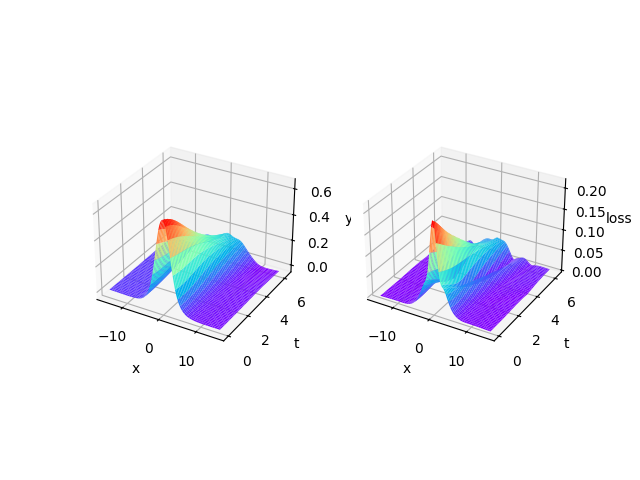

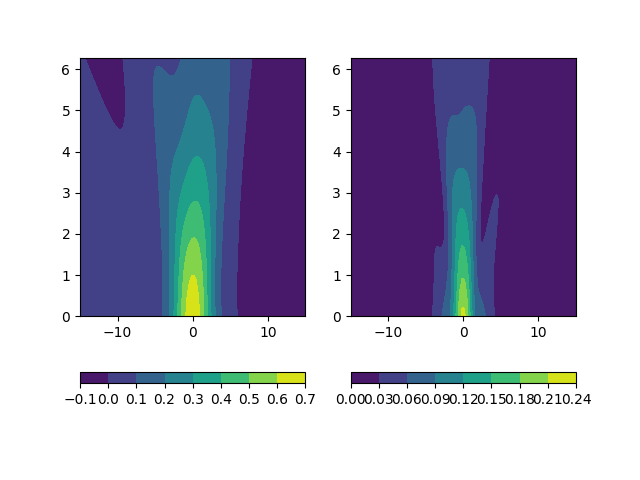

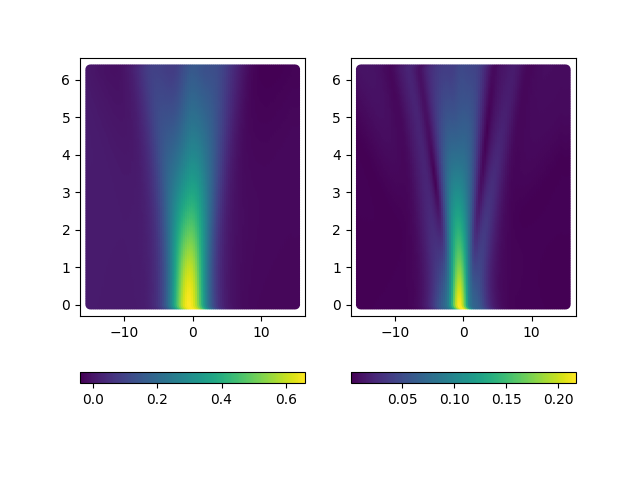

In [19]:
fig1, (ax31, ax32) = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
fig2, (ax21, ax22) = plt.subplots(1, 2)
fig3, (ax11, ax12) = plt.subplots(1, 2)
ax31.set_xlabel('x')
ax31.set_ylabel('t')
ax31.set_zlabel('y')
ax32.set_xlabel('x')
ax32.set_ylabel('t')
ax32.set_zlabel('loss')
ax31.plot_surface(grid_x, grid_t, grid_y, cmap="rainbow")
ax32.plot_surface(grid_x, grid_t, grid_loss_y, cmap="rainbow")
sc = ax21.contourf(grid_x, grid_t, grid_y, s=10)
sc2 = ax22.contourf(grid_x, grid_t, grid_loss_y, s=10)
fig2.colorbar(sc, ax=ax21, orientation="horizontal")
fig2.colorbar(sc2, ax=ax22, orientation="horizontal")
sc3 = ax11.scatter(x, t, c=y)
sc4 = ax12.scatter(x, t, c=loss_y)
fig3.colorbar(sc3, ax=ax11, orientation="horizontal")
fig3.colorbar(sc4, ax=ax12, orientation="horizontal")

In [19]:
plt.close("all")

In [20]:
from gc import collect

torch.cuda.empty_cache(), collect()

(None, 30)

In [78]:
torch.save(model.state_dict(), "model.pt")